In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [14]:
def gaussian(xs, ys, mu_x, mu_y, sigma_x, sigma_y):
    g = np.zeros( (len(xs),len(ys)) )
    for i, x in enumerate(xs):
        for j, y in enumerate(ys):
            g[i,j] = 1/np.sqrt(2*np.pi*sigma_x**2*sigma_y**2)*np.exp( -( (x-mu_x)**2/(2*sigma_x**2) + (y-mu_y)**2/(2*sigma_y**2)))
    return g


def cross_corr(data, ker, ker_size, stride):
       
    pad_x = int((ker_size[0]-1)/2)
    pad_y = int((ker_size[1]-1)/2)    
        
    x = np.arange(-pad_x, pad_x+1)
    y = np.arange(-pad_y, pad_y+1)
    data_pad = np.pad(data, ((pad_x,pad_x),(pad_y, pad_y)), 'mean')
                                            
    cc = np.zeros( (data.shape[0]//stride, data.shape[1]//stride) )
    t = time.time()
    for i in range(pad_x,data.shape[0],stride):        
        for j in range(pad_x,data.shape[1],stride):
            _ker = ker(x,y)
            x_slice = i+x
            y_slice = j+y
            _data = data_pad[x_slice[0]:x_slice[-1]+1,y_slice[0]:y_slice[-1]+1]
            
            _ker = normalize(_ker)
            _data = normalize(_data)
            print(np.sum(np.power(_ker,2)),np.sum(np.power(_data,2))
            cc[i,j] = np.sum(_data*_ker)/(np.sqrt( np.sum(np.power(_data,2)) * np.sum(np.power(_ker,2)) ))
                
    return cc
                          

def highpass(x, y, data, cutoff):
    FFT = np.fft.fft2(cts)
    freq_x = np.fft.fftfreq(cts.shape[0], x[1]-x[0])
    freq_y = np.fft.fftfreq(cts.shape[1], y[1]-y[0])
    
    for i in range(FFT.shape[0]):
        for j in range(FFT.shape[1]):
            if np.abs(freq_x[i]) < cutoff or np.abs(freq_y[j]) < cutoff:
                FFT[i,j] = 0
    
    return np.abs(np.fft.ifft2(FFT))
                      

def denoise(data):
    data_denoised = np.copy(data)
    
    hist, bins = np.histogram(data_denoised.flatten(), bins=int(np.amax(data)/np.amin(data)))
    bin_ctr = 0.5*(bins[1:]+bins[:-1])
    
    fig, axs = plt.subplots(2,1)
    cs = np.cumsum(hist)/np.sum(hist)    
    pctl = np.argmin(np.abs(cs-0.9))
    
    axs[0].plot(bin_ctr, hist, '-b')
    axs[1].plot(bin_ctr[:pctl], hist[:pctl], '-r')
    plt.show()
    thr = float(input('Noise threshold'))
    
    for i in range(data_denoised.shape[0]):
        for j in range(data_denoised.shape[1]):
            if data_denoised[i,j] < thr: 
                data_denoised[i,j] = 0
    
    return data_denoised


def truncate_image(x,y,data):
    for i in range(data.shape[0]):
        if np.amin(data[i:,])==0 and np.amax(data[i,:])==0:
            break
    return x[:i],y,data[:i,:]


def resize_image(x, y, data, xrange, yrange):
    xmin_idx = np.argmin(np.abs(x-xrange[0]))
    xmax_idx = np.argmin(np.abs(x-xrange[1]))
    ymin_idx = np.argmin(np.abs(y-yrange[0]))
    ymax_idx = np.argmin(np.abs(y-yrange[1]))
    return x[xmin_idx:xmax_idx], y[ymin_idx:ymax_idx], data[xmin_idx:xmax_idx, ymin_idx:ymax_idx]


def normalize(data):
    return (data-np.amin(data))/np.amax(data-np.amin(data))

In [3]:
data = np.loadtxt(r"\\qofileserver.physik.uni-ulm.de\hqo1\people\Marco Klotz\tmp_Nuk_Confocal_scan\20210119-1957-54_confocal_xy_image_Dev1Ctr3.dat", comments='#')
# data = np.loadtxt(r"20210118-1318-33_confocal_xy_image_Dev1Ctr3.dat", comments='#')

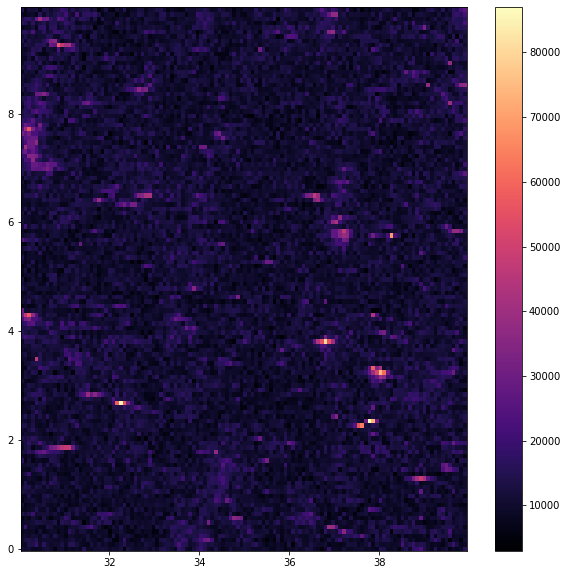

In [15]:
cts = np.copy(data)

xmin = -1.6249999999999999e-04
xmax = 1.6249999999999999e-04
ymin = -1.6249999999999999e-04
ymax = 1.6249999999999999e-04
x = np.linspace(xmin,xmax,cts.shape[0])
y = np.linspace(ymin,ymax,cts.shape[1])

res_x = (xmax-xmin)/cts.shape[0]
res_y = (ymax-ymin)/cts.shape[1]

# X, Y = np.meshgrid(y*1e6, x*1e6)
# plt.pcolormesh(X, Y, cts, cmap='magma')
# plt.colorbar()
# plt.show()

# x, y, cts = truncate_image(x,y,cts)
x, y, cts = resize_image(x, y, cts, [0,10e-6], [30e-6,40e-6])

lbd = 532e-9
NA = 0.95
spotsize = lbd/(2*NA)

X, Y = np.meshgrid(y*1e6, x*1e6)
plt.figure(figsize=(10,10))
plt.pcolormesh(X, Y, cts, cmap='magma')
plt.colorbar()
plt.show()

In [16]:
em_size = 200e-9

sigma_x = np.ceil(em_size/res_x)
sigma_y = np.ceil(em_size/res_x)
ker = lambda x,y: gaussian(x, y, 0, 0, sigma_x, sigma_y)
ker_size = (3*sigma_x if (3*sigma_x)%2==1 else 3*sigma_x+1, 3*sigma_y if 3*(sigma_y%2)==1 else 3*sigma_y+1)
print(ker_size)

(9.0, 10.0)


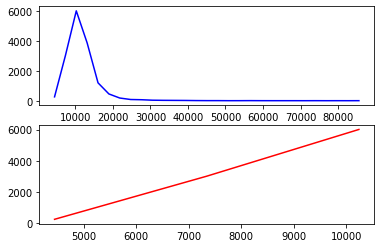

Noise threshold20000


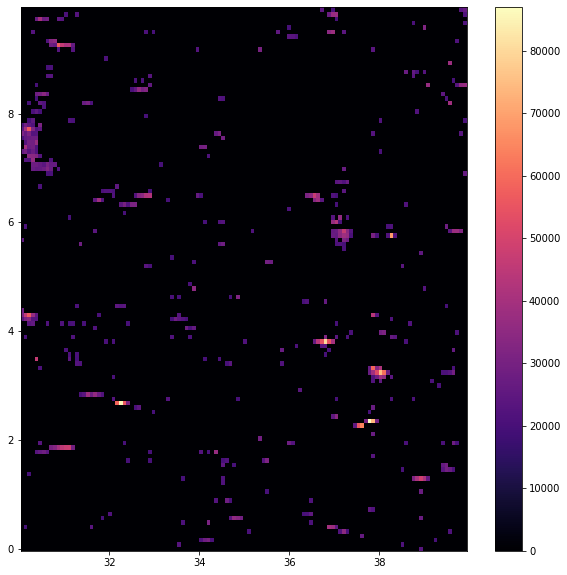

In [17]:
cts_denoised = denoise(cts)
X, Y = np.meshgrid(y*1e6, x*1e6)
plt.figure(figsize=(10,10))
plt.pcolormesh(X, Y, cts_denoised, cmap='magma')
plt.colorbar()
plt.show()

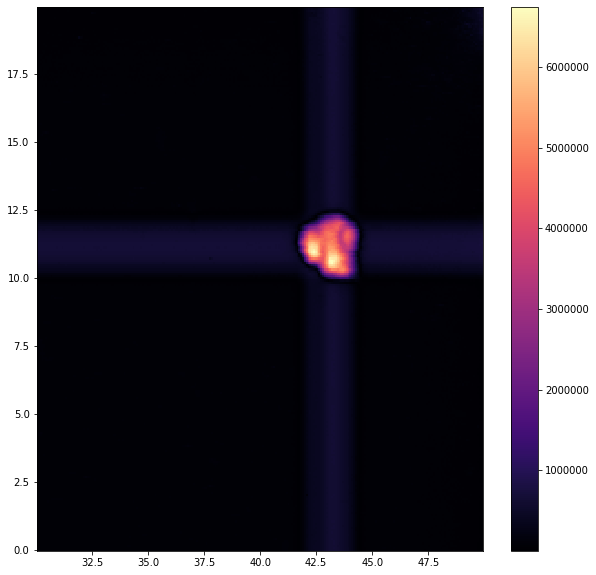

In [33]:
cts_hp = highpass(x,y,cts_denoised,1e3)
plt.figure(figsize=(10,10))
plt.pcolormesh(X,Y, cts_hp, cmap='magma')
plt.colorbar()
plt.show()

In [18]:
cts_cc = cross_corr(cts_denoised, ker, ker_size, 1)
plt.figure(figsize=(10,10))
plt.pcolormesh(X,Y, cts_cc, cmap='magma')
plt.colorbar()
plt.show()

[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]] [[0.23209779 0.23209779 0.23209779 0.23209779 0.46107179 0.7532

[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]] [[0.08964469 0.04546517 0.0672043  0.04394577 0.01484338 0.0058

  0.19275841 0.09667892 0.        ]] [[0.24731183 0.87096774 0.30107527 0.         0.2688172  0.52688172
  0.         1.         0.49462366]
 [0.24731183 0.87096774 0.30107527 0.         0.2688172  0.52688172
  0.         1.         0.49462366]
 [0.24731183 0.87096774 0.30107527 0.         0.2688172  0.52688172
  0.         1.         0.49462366]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19

[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]] [[0.06013324 0.01402525 0.         0.00701262 0.         0.0149

[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]] [[0.15020161 0.18145161 0.19939516 0.1921371  0.13548387 0.0747

  0.19275841 0.09667892 0.        ]] [[0.01969603 0.00775434 0.01721464 0.02807072 0.0094603  0.05738213
  0.1344603  0.05784739 0.07831886]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.0966789

C:\Users\Marco Klotz\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide


 [[0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.69354839 0.91935484 0.98387097 0.66129032 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.3810

[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]] [[0.         0.         0.         0.         0.         0.
  0

  0.19275841 0.09667892 0.        ]] [[0.         0.         0.         0.78181818 0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         1.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.    

[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]] [[0.         0.         0.         0.         0.         0.
  0

  0.19275841 0.09667892 0.        ]] [[0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.72580645]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.    

 [nan nan nan nan nan nan nan nan nan]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]] [[nan nan nan nan nan n

  0.19275841 0.09667892 0.        ]] [[0.         0.         0.         0.         0.55696203 0.87341772
  0.50632911 0.         0.        ]
 [0.         1.         0.94936709 0.63291139 0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.0966789

  0.19275841 0.09667892 0.        ]] [[0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.67741935 0.         0.         0.         0.
  0.         0.         1.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.    

[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]] [[nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan na

 [nan nan nan nan nan nan nan nan nan]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]] [[nan nan nan nan nan n

[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]] [[0.         0.         0.         0.         0.         0.
  0

  0.19275841 0.09667892 0.        ]] [[nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968

  0.19275841 0.09667892 0.        ]] [[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627


  0.19275841 0.09667892 0.        ]] [[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627


[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]] [[0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0

  0.19275841 0.09667892 0.        ]] [[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627


  0.19275841 0.09667892 0.        ]] [[nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968

 [nan nan nan nan nan nan nan nan nan]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]] [[nan nan nan nan nan n

 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]] [[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [

  0.19275841 0.09667892 0.        ]] [[0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.6875     0.83333333 0.9375     0.98958333 1.         0.60416667
  0.         0.         0.        ]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.0966789

  0.19275841 0.09667892 0.        ]] [[nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968

  0.19275841 0.09667892 0.        ]] [[0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.60810811 0.
  0.54054054 0.         1.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.    

  0.19275841 0.09667892 0.        ]] [[0.00570532 0.         0.         0.70175439 0.         0.
  0.         0.         0.        ]
 [0.03451719 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.02838397 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.03893881 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.00656112 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.05719584 0.         0.         0.         0.         0.80701754
  0.9122807  1.         0.8245614 ]
 [0.07773499 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.05206105 0.         0.         0.         0.         0.
  0.80701754 0.         0.        ]
 [0.00827271 0.         0.         0.         0.         0.
  0.         0.         0.        ]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.0966789

  0.19275841 0.09667892 0.        ]] [[nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968

  0.19275841 0.09667892 0.        ]] [[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627


  0.19275841 0.09667892 0.        ]] [[0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.575  0.65   0.7125 0.5875 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.75   0.825  1.    ]
 [0.     0.     0.     0.575  0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.    ]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823

[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]] [[nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan na

  0.19275841 0.09667892 0.        ]] [[0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         1.
  0.         0.88888889 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.    

  0.         0.         0.        ]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]] [[0.         0.         0.

  0.19275841 0.09667892 0.        ]] [[0.         0.         0.         0.         0.         0.
  0.26436782 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.31034483 0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.28735632 0.63793103 0.74137931 0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.35057471 1.
  0.84482759 0.33908046 0.        ]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.    

  0.19275841 0.09667892 0.        ]] [[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627


[[0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.29133917 0.52650344 0.76020964 0.93496823 1.         0.93496823
  0.76020964 0.52650344 0.29133917]
 [0.26460382 0.48705968 0.70813627 0.87345082 0.93496823 0.87345082
  0.70813627 0.48705968 0.26460382]
 [0.19275841 0.38106323 0.56820053 0.70813627 0.76020964 0.70813627
  0.56820053 0.38106323 0.19275841]
 [0.09667892 0.23931325 0.38106323 0.48705968 0.52650344 0.48705968
  0.38106323 0.23931325 0.09667892]
 [0.         0.09667892 0.19275841 0.26460382 0.29133917 0.26460382
  0.19275841 0.09667892 0.        ]] [[nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan na

KeyboardInterrupt: 

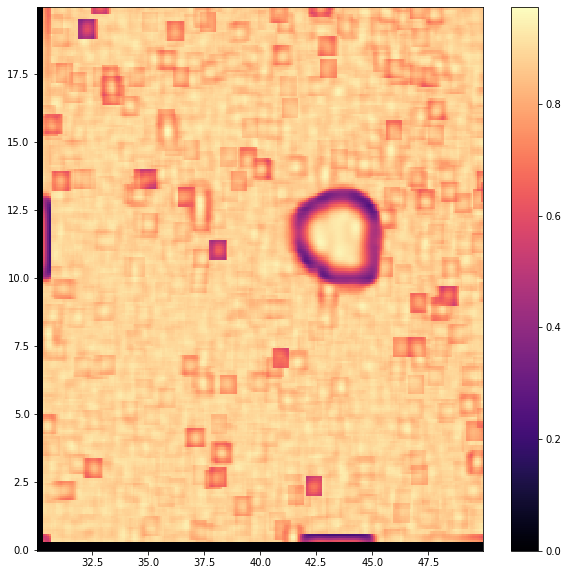

In [44]:
cts_cc = cross_corr(cts_denoised, ker, ker_size, 1)
plt.figure(figsize=(10,10))
plt.pcolormesh(X,Y, cts_cc, cmap='magma')
plt.colorbar()
plt.show()